# Report for the sleep data project

## Introduction


The purpose of this project is to use ensemble methods to discriminate between different sleep stages from EEG sleep data. We experiment with different ensemble methods and parameters in order to compare the results and find the most appropriate approach given our data.

We first prepare and filter the data for further use. Then perform Wavelet decomposition to identify and extract different frequencies from the data. Subsequently, we do feature extraction, where features correspond to the power of the frequency bands. Afterwards, we train and test two different ensemble methods; Random Forest and Adaboost. In order to optimize these results we then perform hyperparameter search and compare the results. To finish we propose and implement further methods to optimize classification.


## Sleep Data Description

Data was collected with the Traumschreiber, high-tech sleep mask developed for research purposes.

The data used to train and test the classifier consists of five data sets corresponding to different nights of sleep. Each data set containing information from seven Electroencephalogram (EEG) channels and one Electrocardiogram (ECG) channel, recorded for about seven hours of sleep.

Data is labeled by epochs of one second, where each second contains about 200 microvolt points. These labels correspond to the sleep stages introduced by the American Academy of Sleep Medicine (AASM) that differentiates between five main sleeping stages: 

(1) Wakefulness: Active wakefulness with beta waves (+13 Hz) and relaxed wakefulness with mostly alpha wave (8-13 Hz).
(2) Non-Rapid Eye Movement (NREM) 1: Dominated by Theta activity (4-7 Hz).
(3) NREM-2: Characterized by Theta waves, sleep spindles and K-complexes.
(4) NREM-3: Dominated by Delta wave (0.5-2 Hz) along with some sleep spindles.
(5) Rapid Eye Movement (REM): Characterized by low-amplitude mixed-frequency brain waves. Theta, alpha and even beta activity can be observed.


In [12]:
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage    
import scipy.signal    
import os
import pickle
from feature_extractor import *

In [13]:
# read the data for subject a
data = pd.read_csv('../src/a_data.csv')
labels = pd.read_csv('../src/a_labels.csv')

### Median filter justification

The data presented huge peaks that where probably product of interference in the Bluetooth signal. To eliminate peaks while altering the data as little as possible, we decided to implement a median filter by using the Scikit median filter function, with a Kernel size of three. This filter runs through the signal entry by entry, replacing each entry with the median of neighboring entries. The pattern of neighbors is referred as the Kernel size.

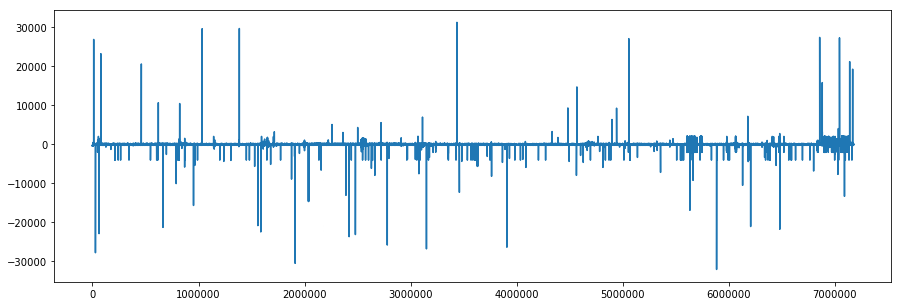

In [14]:
# Example Plot from data set 1, EEG channel 0
plt.figure(figsize = (15,5))
plt.plot(data['Ch0'])
plt.show()

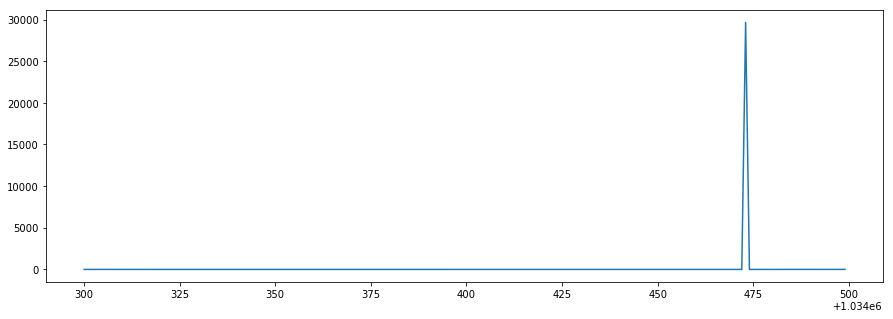

In [11]:
plt.figure(figsize = (15,5))
plt.plot(data['Ch0'][1034300:1034500])
plt.show()

In [15]:
# Median filter implementation loop
pre_processed = scipy.signal.medfilt(data['Ch0'], kernel_size=3)

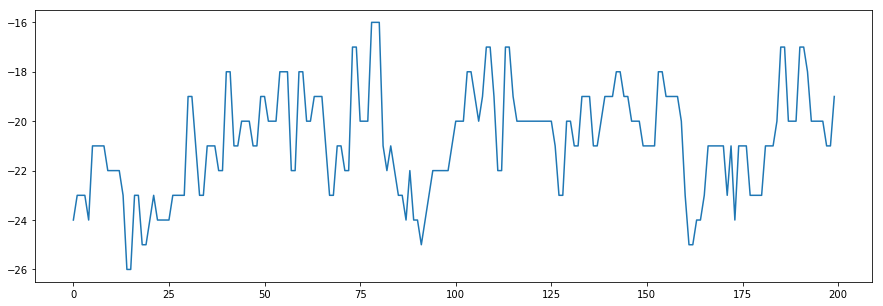

In [16]:
plt.figure(figsize = (15,5))
plt.plot(pre_processed[1034300:1034500])
plt.show()

In [17]:
# group datapoints into bins, corresponding to a second of recording time maybe mit preprocessing
data['TimestampToSec'] = data['Timestamp'].astype(int)
grouped = data.groupby('TimestampToSec')

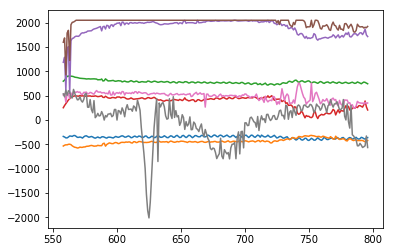

In [18]:
# plot a second of data of all channels

single_sec_data = grouped.get_group(1489016350)
single_sec_ch = single_sec_data['Ch0']

#plt.plot(single_sec_ch)
plt.plot(single_sec_data['Ch0'])
plt.plot(single_sec_data['Ch1'])
plt.plot(single_sec_data['Ch2'])
plt.plot(single_sec_data['Ch3'])
plt.plot(single_sec_data['Ch4'])
plt.plot(single_sec_data['Ch5'])
plt.plot(single_sec_data['Ch6'])
plt.plot(single_sec_data['Ch7'])



plt.show()


## Discrete Wavelet Transform

### Discrete Wavelet Transform Overview

### Feature Extraction for sleep classification 

In [ ]:
mode = pywt.Modes.smooth

def signal_decomp(data):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet('db4')
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)  
    return ca, cd

In [ ]:
def Energy(coeffs, k):
    return np.sqrt(np.sum(np.array(coeffs[-k]) ** 2)) / len(coeffs[-k])

In [ ]:
def plot_signal_decomp(data, w, title):
    ca, cd = signal_decomp(data)
        
    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(12,10))
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title, fontsize=20)
    ax_main.plot(data)
    ax_main.set_xlim(data.index[0], data.index[len(data) - 1])

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


In [ ]:
plot_signal_decomp(single_sec_ch, 'db4', "Single Sec single Channel EEG data")
plt.show()

### ignore from here

In [ ]:
# CONSTRUCT FEATURES

# for every label, look up the corresponding data
features = []
for l in range(len(labels)):
    try:
        time = labels['Timestamp'][l]
        slice = grouped.get_group(time)
    except KeyError:
        print(time)
        pass
    # for every channel
    power_all_channels = []
    # 1-7 EEG, 8th channel is ECG data
    for ch in range(8):
        single_sec_ch = slice['Ch{}'.format(ch)]
        
        # median filter the data
        pre_processed = scipy.signal.medfilt(single_sec_ch, kernel_size=3)  
        
        _, cd = signal_decomp(pre_processed)
        # for every decomp. level
        power = []
        for l in range(5):
            power.append(Energy(cd, l))
            
        # collect power for all channels into one vector 
        power_all_channels.append(power) 
    # currently mean power of the frequency bands over all channels are the only features
    power_vec = np.asarray(power_all_channels).flatten()
    features.append(power_vec)
features =np.asarray(features)
 

In [ ]:
print(features.shape)

## Classification

### Random Forest

### AdaBoost

### Smoothing Bayesian

## Results

## Conclusion